In [ ]:
!pip install -U pgmpy --quiet

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 50.9 MB/s eta 0:00:00


In [ ]:
!pip show pgmpy

Name: pgmpy
Version: 1.0.0
Summary: A library for Probabilistic Graphical Models
Home-page: https://github.com/pgmpy/pgmpy
Author: Ankur Ankan
Author-email: ankurankan@gmail.com
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: joblib, networkx, numpy, opt-einsum, pandas, pyro-ppl, scikit-learn, scipy, statsmodels, torch, tqdm
Required-by: 


Dataset loaded successfully!
Shape: (30, 17)
Columns: ['Rainfall', 'SoilSaturation', 'RiverLevel', 'Drainage', 'InfrastructureAge', 'PopulationDensity', 'WindSpeed', 'TransformerLoad', 'SanitationLevel', 'Flood', 'Landslide', 'Bridge_Collapse', 'Water_Borne_Disease', 'Power_Grid_Failure', 'Road_Blockage', 'Delayed_Rescue', 'CommunicationFailure']

Sample records:
    Rainfall SoilSaturation RiverLevel   Drainage InfrastructureAge  \
0      High           High       High       Poor               Old   
1      High           High       High       Poor               Old   
2      High           High       High       Poor               New   
3       Low            Low        Low  Efficient               New   
4  Moderate       Moderate   Moderate   Moderate               Old   

  PopulationDensity WindSpeed TransformerLoad SanitationLevel Flood Landslide  \
0             Dense      High            High            Poor   Yes       Yes   
1         VeryDense      High            High     

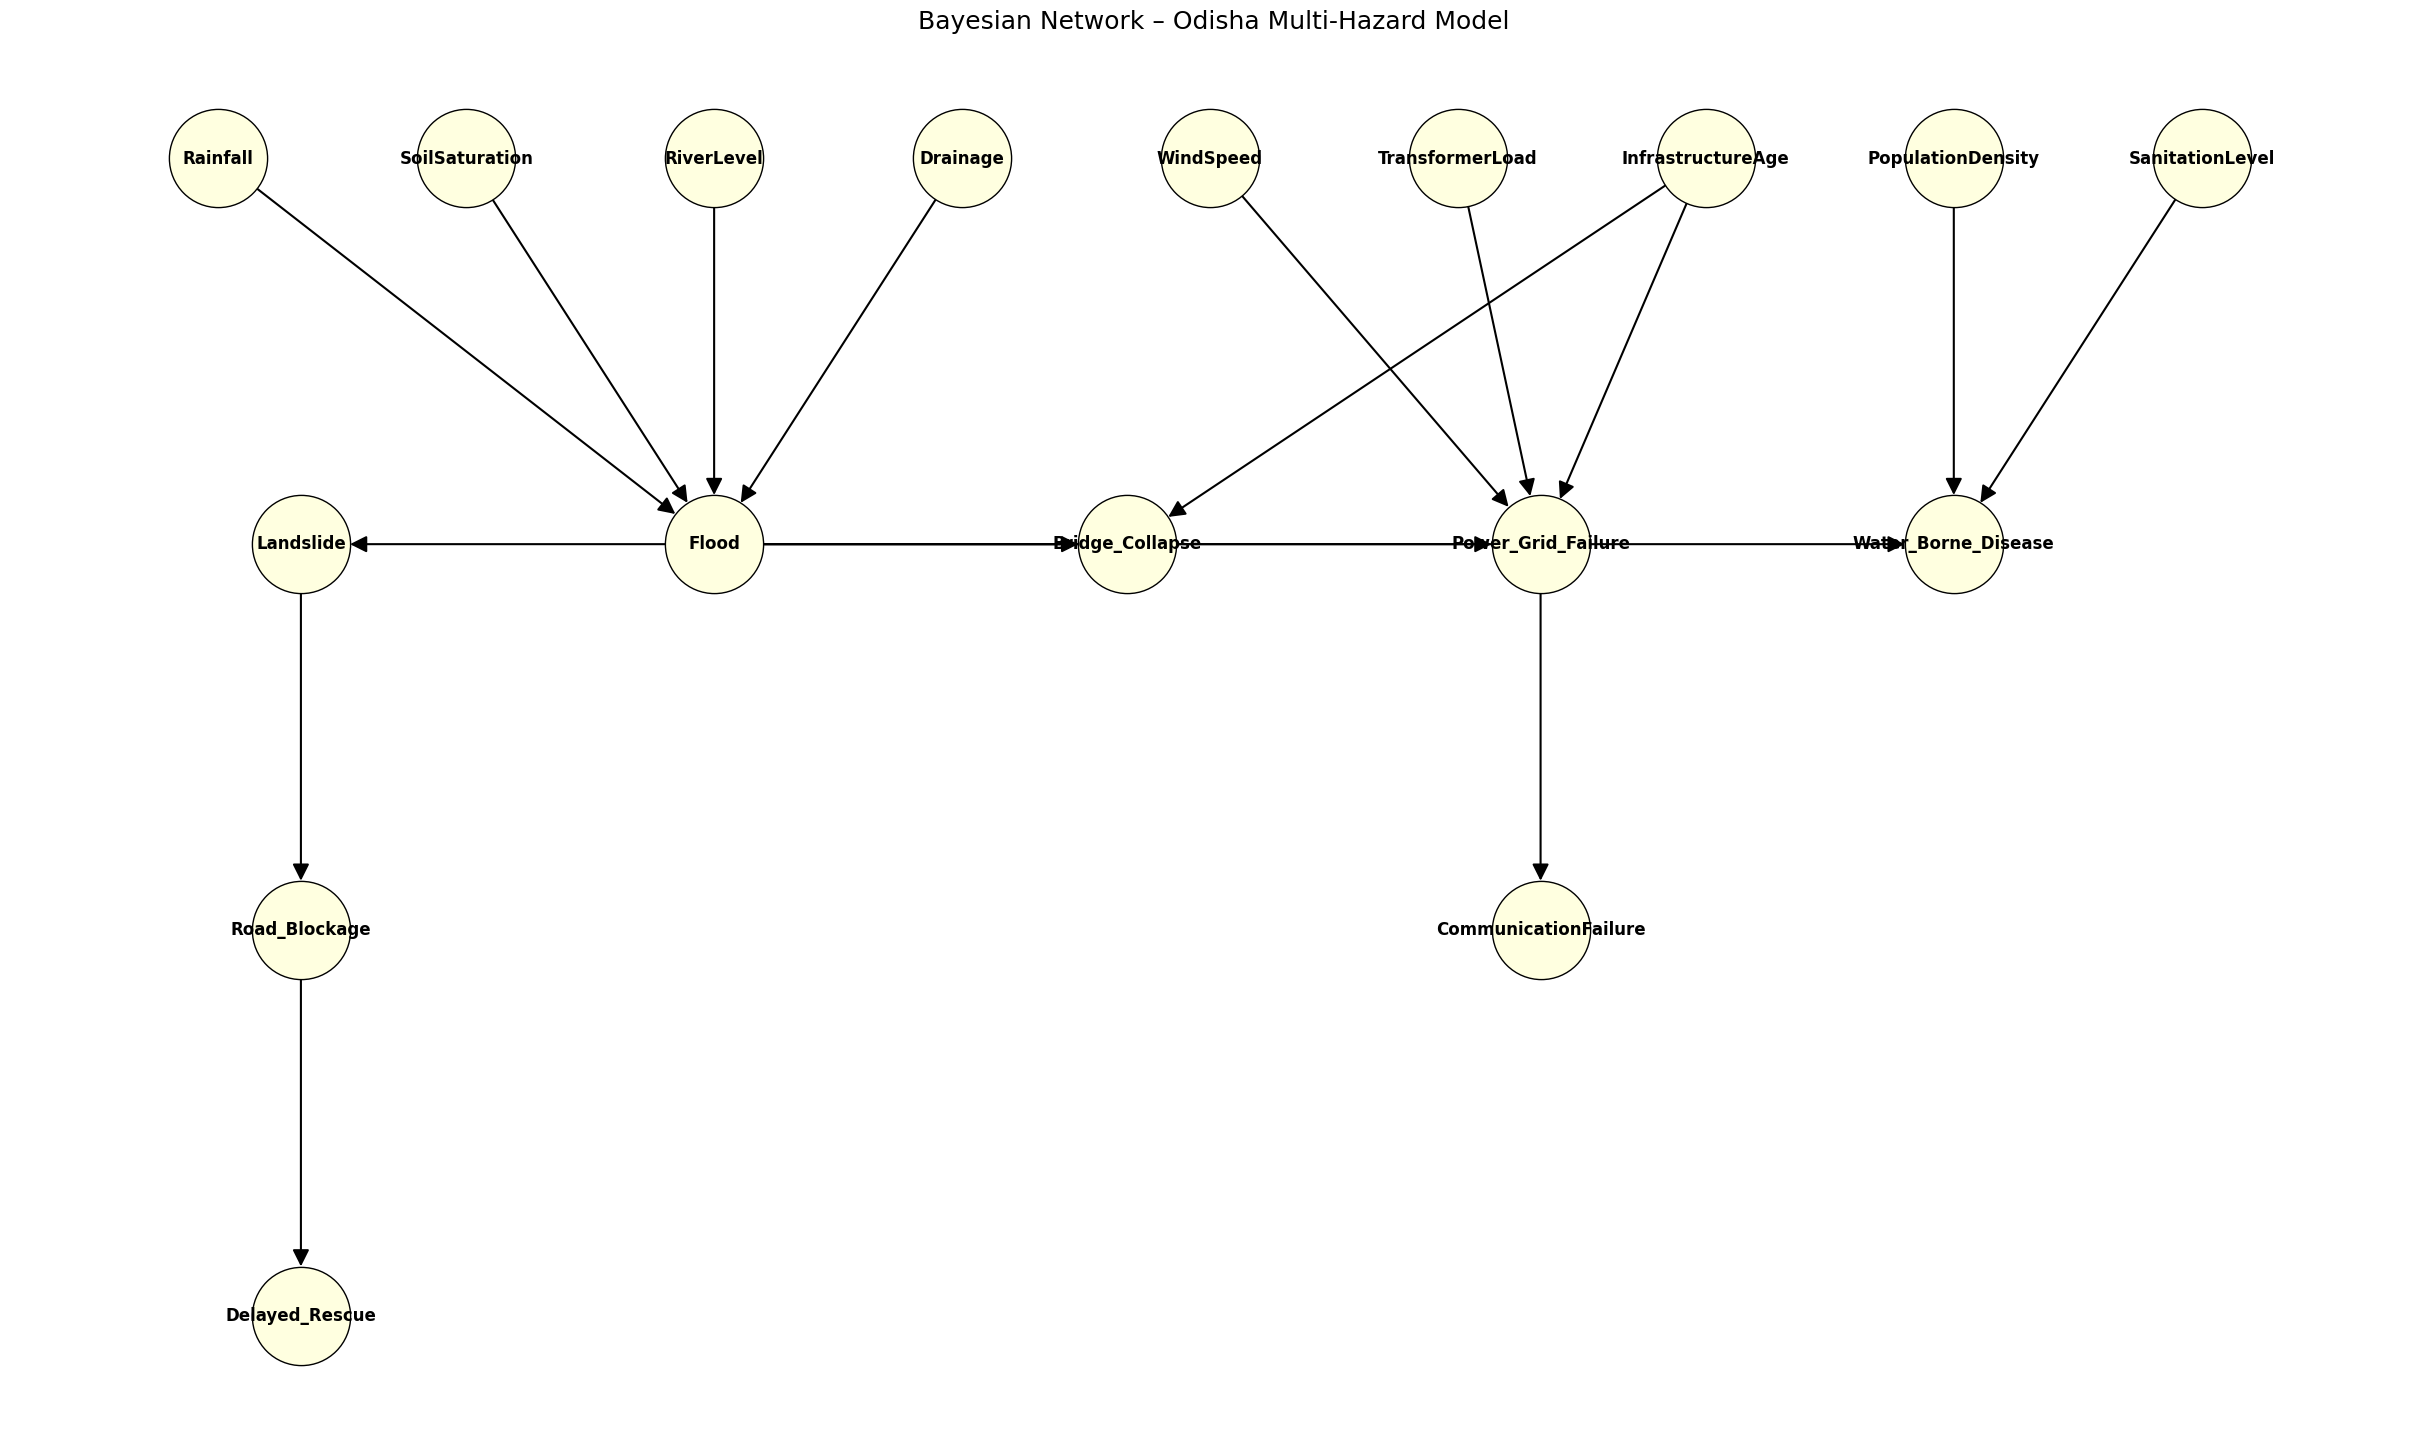


 Conditional Probability Tables (CPTs):

+--------------------+----------+
| Rainfall(High)     | 0.504762 |
+--------------------+----------+
| Rainfall(Low)      | 0.247619 |
+--------------------+----------+
| Rainfall(Moderate) | 0.247619 |
+--------------------+----------+ 

+-----------------+-----+--------------------------+
| Drainage        | ... | Drainage(Poor)           |
+-----------------+-----+--------------------------+
| Rainfall        | ... | Rainfall(Moderate)       |
+-----------------+-----+--------------------------+
| RiverLevel      | ... | RiverLevel(Moderate)     |
+-----------------+-----+--------------------------+
| SoilSaturation  | ... | SoilSaturation(Moderate) |
+-----------------+-----+--------------------------+
| Flood(Moderate) | ... | 0.33333333333333337      |
+-----------------+-----+--------------------------+
| Flood(No)       | ... | 0.33333333333333337      |
+-----------------+-----+--------------------------+
| Flood(Yes)      | ... | 0.3

In [ ]:


data = pd.read_csv("/odisha_data.csv")

print("Dataset loaded successfully!")
print("Shape:", data.shape)
print("Columns:", list(data.columns))
print("\nSample records:\n", data.head())

structure = [


    ('Rainfall', 'Flood'),
    ('SoilSaturation', 'Flood'),
    ('RiverLevel', 'Flood'),
    ('Drainage', 'Flood'),

    ('Flood', 'Landslide'),
    ('Flood', 'Bridge_Collapse'),
    ('Flood', 'Water_Borne_Disease'),
    ('Flood', 'Power_Grid_Failure'),

    ('WindSpeed', 'Power_Grid_Failure'),
    ('TransformerLoad', 'Power_Grid_Failure'),
    ('InfrastructureAge', 'Power_Grid_Failure'),

    ('InfrastructureAge', 'Bridge_Collapse'),

    ('PopulationDensity', 'Water_Borne_Disease'),
    ('SanitationLevel', 'Water_Borne_Disease'),

    ('Landslide', 'Road_Blockage'),
    ('Road_Blockage', 'Delayed_Rescue'),

    ('Power_Grid_Failure', 'CommunicationFailure')
]


G = nx.DiGraph()
G.add_edges_from(structure)

pos = {

    'Rainfall': (-6, 4),
    'SoilSaturation': (-3, 4),
    'RiverLevel': (0, 4),
    'Drainage': (3, 4),

    'WindSpeed': (6, 4),
    'TransformerLoad': (9, 4),
    'InfrastructureAge': (12, 4),
    'PopulationDensity': (15, 4),
    'SanitationLevel': (18, 4),


    'Flood': (0, 2),
    'Power_Grid_Failure': (10, 2),
    'Water_Borne_Disease': (15, 2),
    'Bridge_Collapse': (5, 2),
    'Landslide': (-5, 2),

    'Road_Blockage': (-5, 0),
    'CommunicationFailure': (10, 0),

    'Delayed_Rescue': (-5, -2)
}

plt.figure(figsize=(24, 14))

nx.draw(
    G, pos,
    with_labels=True,
    node_size=5000,
    node_color='lightyellow',
    font_size=12,
    font_weight='bold',
    edgecolors='black',
    arrowsize=25,
    width=1.5
)

plt.title(" Bayesian Network – Odisha Multi-Hazard Model", fontsize=18)
plt.axis('off')
plt.show()

model = DiscreteBayesianNetwork(structure)

model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)

print("\n Conditional Probability Tables (CPTs):\n")
for cpd in model.get_cpds():
    print(cpd, "\n")

queries = pd.read_csv("/queries.csv")
print("\n Queries loaded successfully!")
print(queries.head())

infer = VariableElimination(model)
results = []

for idx, row in queries.iterrows():
    target_var = str(row['TargetVariable']).strip()
    evidence_str = str(row['Evidence']).strip()

    try:
        evidence = ast.literal_eval(evidence_str)
        if not isinstance(evidence, dict):
            raise ValueError("Evidence must be a dictionary")
    except Exception as e:
        print(f"Error parsing evidence for Query {idx+1}: {e}")
        results.append({
            "Query_No": idx + 1,
            "TargetVariable": target_var,
            "Evidence": evidence_str,
            "Result": f"Parsing error: {e}"
        })
        continue

    print(f"\n Query {idx+1}: Predicting '{target_var}' with evidence {evidence}")

    try:
        query_result = infer.query(variables=[target_var], evidence=evidence)
        print(query_result)

        results.append({
            "Query_No": idx + 1,
            "TargetVariable": target_var,
            "Evidence": str(evidence),
            "Result": query_result.__str__().replace("\n", " ")
        })

    except Exception as e:
        print(f"Error running query {idx+1}: {e}")
        results.append({
            "Query_No": idx + 1,
            "TargetVariable": target_var,
            "Evidence": str(evidence),
            "Result": f"Query error: {e}"
        })


results_df = pd.DataFrame(results)
results_df.to_csv("query_results.csv", index=False)

print("\n All query results saved to 'query_results.csv'!")
